# Mulilayer Perceptron

A deep learning technique for classification is the multilayer perceptron. Because MLP is a deep learning technique that performs best when fed massive amounts of data, we only use the "KNN Imputations" method in this notebook. When compared to the manually cleaned method, our KNN Imputation method yields a much longer dataset by filling in missing values and altering and clustering some of the data.

## Import necessary libraries

In [209]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [210]:
data = pd.read_csv('data/dementia_patients_cleaned_2_After EDA.csv')
data.head(5)

,Diabetic,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Age,Education_Level,Dominant_Hand,Gender,Family_History,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,True,98,96.230743,36.224852,57.563978,36.421028,60,2,Left,Female,False,2,False,1,True,10,Low-Carb Diet,False,True,0
1,False,78,93.032122,36.183874,56.832335,31.157633,61,3,Right,Male,False,1,True,3,True,1,Low-Carb Diet,False,True,1
2,False,89,93.566504,37.326321,59.759066,37.640435,69,2,Right,Male,True,1,False,3,True,8,Mediterranean Diet,False,True,0
3,False,60,93.906510,37.030620,58.266471,50.673992,78,3,Left,Female,True,0,False,2,True,5,Balanced Diet,False,True,1
4,True,67,97.508994,36.062121,67.705027,27.810601,77,3,Right,Male,True,0,True,2,True,0,Low-Carb Diet,True,True,1


In [211]:
X = data.drop('Dementia', axis=1)
y = data['Dementia'].astype(np.float32)
print('Len of X', len(X))
print('Len of y', len(y))

Len of X 1000
Len of y 1000


In [212]:
# Assume that 'Dominant_Hand', 'Gender', and 'Nutrition_Diet' are the categorical columns
categorical_cols = ['Dominant_Hand', 'Gender', 'Nutrition_Diet']
data = pd.get_dummies(data, columns=categorical_cols)

# Convert boolean columns to integer
bool_cols = ['Diabetic', 'Family_History', 'APOE_ε4', 'Depression_Status', 'Sleep_Quality', 'Chronic_Health_Conditions']
for col in bool_cols:
    data[col] = data[col].astype(int)

# Define columns that need to be scaled
numerical_cols = ['HeartRate', 'BloodOxygenLevel', 'BodyTemperature', 'Weight', 'MRI_Delay', 'Age', 
                  'Physical_Activity', 'Cognitive_Test_Scores', 'Smoking_Status', 'Education_Level']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Split the dataset into features and target variable
X = data.drop('Dementia', axis=1).values  # Convert DataFrame to numpy array
y = data['Dementia'].astype(np.float32).values  # Convert Series to numpy array

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Pytorch Dataset:
This Python dataset can be used with the Python library.  
- Normalize the data  
- Convert it to a Pytorch tensor

In [213]:
class DementiaDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [214]:
# Create dataset instances
train_data = DementiaDataset(X_train_scaled, y_train)
test_data = DementiaDataset(X_test_scaled, y_test)

# Create DataLoader instances
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [215]:
next(iter(train_loader))

[tensor([[-1.0487, -1.1649, -1.5822, -0.4561, -0.9643,  0.6982, -0.4108, -0.5062,
           0.9656,  0.5739,  0.6683, -1.2264,  0.0000, -1.4168, -0.9276,  0.0000,
           0.9802, -0.9802, -1.0356,  1.0356, -0.7157,  1.4089, -0.6959],
         [ 0.9536, -0.4208, -1.6928,  1.0746, -0.0360,  0.6580, -0.8548, -0.5062,
           0.9656, -0.9720,  0.6683,  1.2449,  0.0000,  0.8056,  1.0780,  0.0000,
           0.9802, -0.9802, -1.0356,  1.0356, -0.7157,  1.4089, -0.6959],
         [-1.0487,  0.3233,  0.1900,  0.1342,  0.8760, -1.2375,  1.4760,  0.5680,
          -1.0356, -0.9720,  0.6683,  1.2449,  0.0000, -0.4643,  1.0780,  0.0000,
          -1.0202,  1.0202,  0.9656, -0.9656, -0.7157, -0.7098,  1.4371],
         [-1.0487, -1.5782, -1.4637,  1.2013,  1.5851,  0.3583, -1.2987,  0.5680,
          -1.0356,  0.5739,  0.6683,  0.0093,  0.0000, -1.4168,  1.0780,  0.0000,
           0.9802, -0.9802, -1.0356,  1.0356,  1.3972, -0.7098, -0.6959],
         [-1.0487, -1.5782,  1.4310,  1.4715, -0

## Model Optimization  
We use this model to utilizes the Adam optimizer for efficient stochastic optimization, well-suited for large datasets and high-dimensional parameter spaces. The loss function employed is the Binary Cross Entropy Loss (BCELoss), which is ideal for binary classification problems, calculating the difference between two probability distributions.


In [216]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims// 2)
        self.linear3 = nn.Linear(hidden_dims// 2, hidden_dims//4)
        self.output = nn.Linear(hidden_dims//4, output_dims)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        out = self.output(x)
        out = self.sigmoid(out)
        return out.squeeze(1)

In [217]:
input_dims = X_train.shape[1]  # Adjust this to match the actual number of features

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP(input_dims=input_dims, hidden_dims=64, output_dims=1).to(device)

In [218]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Model Training

In [219]:
# Define lists to store metrics
train_losses = []
test_losses = []
train_accs = []
test_accs = []
train_precisions = []
test_precisions = []
train_recalls = []
test_recalls = []
train_f1_scores = []
test_f1_scores = []

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_targets = []
    train_predictions = []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        predicted = outputs.round()
        train_predictions.extend(predicted.detach().cpu().numpy())
        train_targets.extend(y.detach().cpu().numpy())
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = accuracy_score(train_targets, train_predictions)
    train_accs.append(train_acc)
    train_precision = precision_score(train_targets, train_predictions)
    train_precisions.append(train_precision)
    train_recall = recall_score(train_targets, train_predictions)
    train_recalls.append(train_recall)
    train_f1 = f1_score(train_targets, train_predictions)
    train_f1_scores.append(train_f1)

    model.eval()
    test_loss = 0.0
    test_targets = []
    test_predictions = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            predicted = outputs.round()
            test_predictions.extend(predicted.detach().cpu().numpy())
            test_targets.extend(y.detach().cpu().numpy())
            loss = criterion(outputs, y)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc = accuracy_score(test_targets, test_predictions)
    test_accs.append(test_acc)
    test_precision = precision_score(test_targets, test_predictions)
    test_precisions.append(test_precision)
    test_recall = recall_score(test_targets, test_predictions)
    test_recalls.append(test_recall)
    test_f1 = f1_score(test_targets, test_predictions)
    test_f1_scores.append(test_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")

Epoch 1/100, Train Loss: 0.6225, Train Accuracy: 0.7250, Train Precision: 0.6653, Train Recall: 0.8443, Train F1 Score: 0.7442, Test Loss: 0.4515, Test Accuracy: 0.8650, Test Precision: 0.9759, Test Recall: 0.7642, Test F1 Score: 0.8571
Epoch 2/100, Train Loss: 0.2539, Train Accuracy: 0.9300, Train Precision: 0.9499, Train Recall: 0.8997, Train F1 Score: 0.9241, Test Loss: 0.1083, Test Accuracy: 0.9650, Test Precision: 1.0000, Test Recall: 0.9340, Test F1 Score: 0.9659
Epoch 3/100, Train Loss: 0.0678, Train Accuracy: 0.9838, Train Precision: 0.9919, Train Recall: 0.9736, Train F1 Score: 0.9827, Test Loss: 0.0750, Test Accuracy: 0.9500, Test Precision: 1.0000, Test Recall: 0.9057, Test F1 Score: 0.9505
Epoch 4/100, Train Loss: 0.0292, Train Accuracy: 0.9925, Train Precision: 1.0000, Train Recall: 0.9842, Train F1 Score: 0.9920, Test Loss: 0.0549, Test Accuracy: 0.9650, Test Precision: 1.0000, Test Recall: 0.9340, Test F1 Score: 0.9659
Epoch 5/100, Train Loss: 0.0119, Train Accuracy: 1.0

Epoch 40/100, Train Loss: 0.0001, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 0.0273, Test Accuracy: 0.9850, Test Precision: 1.0000, Test Recall: 0.9717, Test F1 Score: 0.9856
Epoch 41/100, Train Loss: 0.0000, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 0.0276, Test Accuracy: 0.9850, Test Precision: 1.0000, Test Recall: 0.9717, Test F1 Score: 0.9856
Epoch 42/100, Train Loss: 0.0000, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 0.0269, Test Accuracy: 0.9850, Test Precision: 1.0000, Test Recall: 0.9717, Test F1 Score: 0.9856
Epoch 43/100, Train Loss: 0.0000, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 0.0269, Test Accuracy: 0.9850, Test Precision: 1.0000, Test Recall: 0.9717, Test F1 Score: 0.9856
Epoch 44/100, Train Loss: 0.0000, Train Accuracy

Epoch 81/100, Train Loss: 0.0000, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 0.0267, Test Accuracy: 0.9900, Test Precision: 1.0000, Test Recall: 0.9811, Test F1 Score: 0.9905
Epoch 82/100, Train Loss: 0.0000, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 0.0267, Test Accuracy: 0.9900, Test Precision: 1.0000, Test Recall: 0.9811, Test F1 Score: 0.9905
Epoch 83/100, Train Loss: 0.0000, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 0.0268, Test Accuracy: 0.9900, Test Precision: 1.0000, Test Recall: 0.9811, Test F1 Score: 0.9905
Epoch 84/100, Train Loss: 0.0000, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000, Test Loss: 0.0269, Test Accuracy: 0.9900, Test Precision: 1.0000, Test Recall: 0.9811, Test F1 Score: 0.9905
Epoch 85/100, Train Loss: 0.0000, Train Accuracy

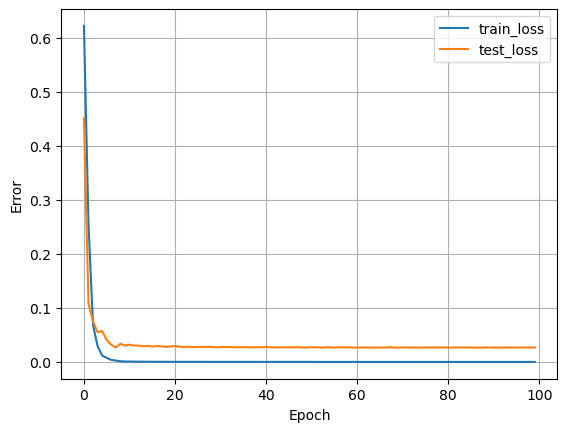

In [222]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.title('Error Graph')

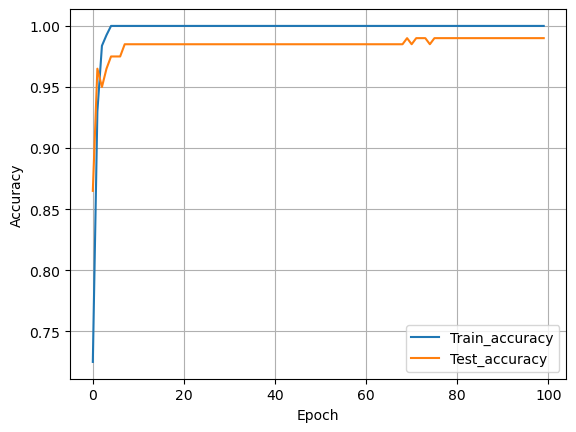

In [223]:
plt.plot(train_accs, label='Train_accuracy')
plt.plot(test_accs, label='Test_accuracy')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Accuracy Graph')

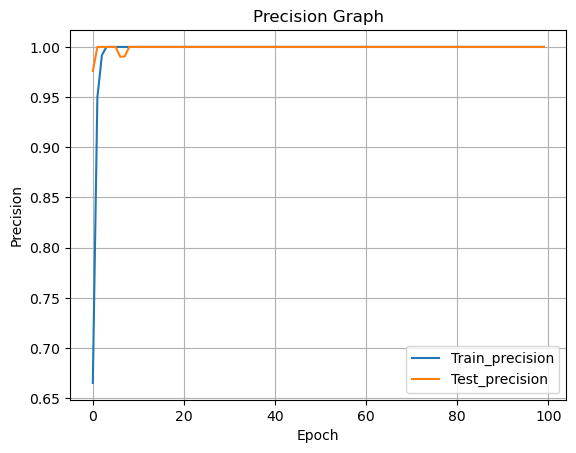

In [228]:
plt.plot(train_precisions, label='Train_precision')
plt.plot(test_precisions, label='Test_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.title('Precision Graph')
plt.show()

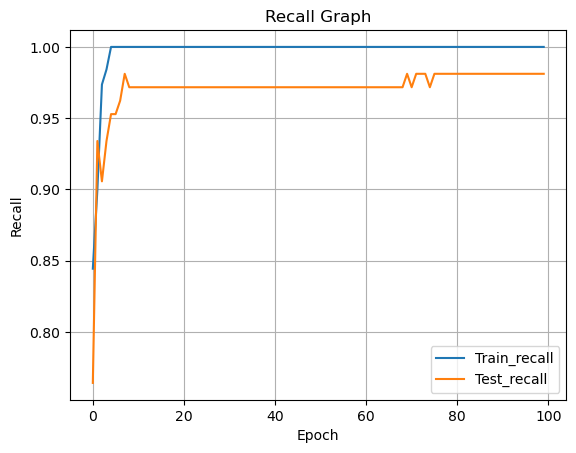

In [229]:
plt.plot(train_recalls, label='Train_recall')
plt.plot(test_recalls, label='Test_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.title('Recall Graph')
plt.show()

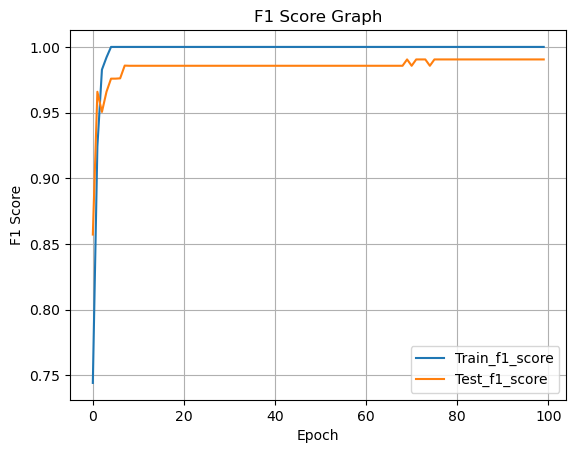

In [226]:
plt.plot(train_f1_scores, label='Train_f1_score')
plt.plot(test_f1_scores, label='Test_f1_score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.title('F1 Score Graph')
plt.show()

To conclude our findings From the test set of our logistic regression model, we obtained the following: Accuracy = 0.740, Precision = 0.715, Recall = 0.809, F1 Score = 0.759.

From the test Epoch 100/100 of our MLP model, we obtained the following: Accuracy: 0.9900, Precision: 1.0000, Recall: 0.9811, F1 Score = 0.9905.

Since MLP F1 Score > LR F1 Score, we conclude that MLP is the better model.